# Практика. 

Рассмотрим одну из самых популярных прикладных задач - рекомендательную систему.

Рассмотрим задачу рекомендации фильмов. Данные о рейтинге фильмов можно скачать тут: 
https://cloud.mail.ru/public/CSjR/mPctRVc2u

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [3]:
data = pd.read_csv('data/user_ratedmovies.dat', sep='\t')
data.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


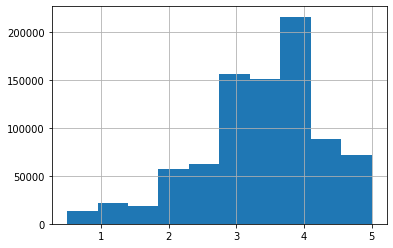

In [4]:
data['rating'].hist()
plt.show()

 Есть 2 разновидности обучения рекомендательных систем: 
 
 1) explicit feedback -- пользователь ставит оценку объекту
 
 2) implicit feedback -- мы понимаем, понравился объект или не понравится по неявному взаимодействию пользователя с системой
 


Как мы в итоге проставлям таргеты?

Все большие рекомендательные системы состоят из двух частей

1) Черновой отбор кандидатов

2) Финальная модель


# Часть 1. Отбираем кандидатов с помощью расстояния

Простые варианты чернового отбора:

1) Самые популярные/новые фильмы

2) Фильмы, которые как-то связаны с человеком

Как свзяны? Какой подход лучше?

Будем пытаться найти в нашей базе похожие фильмы. Если человеку понравился
фильм А, будем для финальной модели отдавать фильмы, похожие на этот
Возьмем все фильмы, которые понравились пользователям. Базовая гипотеза --  фильмы, которые  смотрят вместе одни люди скорее будут похожими.  


In [19]:
liked_data = data[data.rating >= 3]
print (liked_data.shape)

(682605, 9)


In [10]:
users = list(liked_data['userID'])
movies = list(liked_data['movieID'])

In [21]:
user2movies = {}
for i in range(len(users)):
    user_id = users[i]
    movie_id = movies[i]
    if user_id not in user2movies:
        user2movies[user_id] = set()
    user2movies[user_id].add(movie_id)

### Pointwise mutual information 
Часто используемая мера связи между категориальными признаками. 
$$PMI(x,y) = \log \frac{p(x,y)}{p(x) p(y)} $$
В дискретном случае, если всего $N$ событий и мы хотим посчитать вероятность, что $x, y$ встретились вместе:
$$PMI(x,y) = \log \frac{n_{x,y}  N}{n_x, n_y}, $$
где $n_x - $ число событий где встретилось $x$,  $n_y - $ число событий где встретилось $y, n_{x,y} - $ число событий где встретились вместе $x$ и $y$, $N$ - общее число событий

In [40]:
pairs_count = {}
movies_count = {}
for k, new_user in enumerate(user2movies):
    movies = list(user2movies[new_user]) 
    for i in range(len(movies)):
        i_movie = movies[i]
        if i_movie not in movies_count:
            movies_count[i_movie] = 0
        movies_count[i_movie] += 1
        for j in range(i + 1, len(movies)):
            j_movie = movies[j]
            assert (i_movie != j_movie)
            if i_movie < j_movie:
                pair = (i_movie, j_movie)
            else:
                pair = (j_movie, i_movie)
            if pair not in pairs_count:
                pairs_count[pair] = 0
            pairs_count[pair] += 1

KeyboardInterrupt: 

найдем похожие фильмы на мой любимый по PMI!

In [35]:
movies_data = pd.read_csv('data/movies.dat', sep='\t',  encoding = "ISO-8859-1")
movies_data[movies_data.id == 1 ]

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...


In [36]:
scores = []
REG_THR = 300
for i in pairs_count:
    if pairs_count[i] < REG_THR:
        continue
    score = pairs_count[i] / (movies_count[i[0]] * movies_count[i[1]])
    if i[0] == 1:
        scores.append((score, i[1]))
top_sim_docs = [i[1] for i in sorted(scores, reverse=True)][0:30]

In [37]:
all_words = ""
for i in top_sim_docs:
    new_tile = movies_data[movies_data.id == i ].title.values[0]
    print (new_tile)
    all_words += " " + movies_data[movies_data.id == i ].title.values[0]

In [38]:
all_words = ""
for i in top_sim_docs:
    new_tile = movies_data[movies_data.id == i ].title.values[0]
    print (new_tile)
    all_words += " " + movies_data[movies_data.id == i ].title.values[0]

In [39]:
wordcloud = WordCloud().generate(all_words)
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

# Часть 2. Делаем финальную модель регрессии

In [41]:
train_data = data[data.date_year < 2008] 
test_data = data[ (data.date_year == 2008) & (data.userID.isin(train_data.userID))] 
print (train_data.shape)
print (test_data.shape)

(712092, 9)
(56232, 9)


In [43]:
history_data = train_data[train_data.date_year < 2007]
train_data = train_data[train_data.date_year == 2007]

In [44]:
liked_data = history_data[data.rating >= 3]
users = list(history_data['userID'])
movies = list(history_data['movieID'])
ratings = list(history_data['rating'])
user2movies = {}
for i in range(len(users)):
    user_id = str(users[i])
    movie_id = str(movies[i])
    rating =  ratings[i]
    if rating >= 3:
        liked = '1'
    else:
        liked = '-1'
    if user_id not in user2movies:
        user2movies[user_id] = set()
    user2movies[user_id].add('{}:{}'.format(movie_id, liked))


/home/maxkile/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [46]:
def to_vw_format(user_id, film_id, target=None):
    if user_id in user2movies:
        user_films = user2movies[user_id]
    else:
        user_films = ['-1:-1']
    return str(target or '') + ' |u ' + str(user_id)  + ' |f ' + str(film_id) + ' |h ' + ' '.join(user_films)+ '\n'

In [47]:
to_vw_format('26624', '3')

' |u 26624 |f 3 |h 2021:-1 901:1 858:1 1161:1 6350:1 5291:1 953:1 26150:1 2150:1 2728:-1 1270:1 7238:-1 6539:1 18:-1 1210:-1 4272:1 1200:-1 2640:-1 2019:1 2617:-1 1249:1 3910:1 6969:1 3742:-1 8656:1 7577:1 5945:-1 8636:-1 4881:1 1298:-1 1251:1 1216:1 8370:-1 5888:1 1193:-1 3310:1 1580:1 8292:1 8368:-1 3578:-1 4896:-1 1450:1 2012:-1 8012:1 26662:1 4306:1 2931:1 3000:1 1951:1 2762:-1 7063:-1 8199:1 3357:1 7234:1 8604:1 2011:-1 260:-1 4993:-1 3462:1 6792:-1 714:1 2701:-1 914:1 1079:1 8025:1 2971:1 1211:1 5952:-1 2843:-1 8794:-1 33493:-1 8372:-1 4223:-1 1196:-1 916:1 1214:-1 1232:1 3328:1 1960:1 3503:1 5991:1 8327:1 2018:1 70:-1 8360:-1 2068:1 3114:-1 26776:1 1246:1 2686:1 2116:1 2722:-1 7153:-1 308:1 6433:1 1243:1 4973:1 2858:-1 2953:-1 8125:1 3030:1 2571:-1 912:1 5690:1 236:-1 1225:1 2672:-1 7925:1 5971:1 7371:1 1747:1 6793:-1 915:1 4788:1 6492:1 6542:1 1961:1 8154:1 27834:1\n'

In [48]:

with open('train.vw', 'w') as of:
    for i in range(len(train_data)):
        new_data = train_data.iloc[i]
        user_id = str(int(new_data['userID']))
        movie_id = int(new_data['movieID'])
        target = new_data['rating']
        of.write(to_vw_format(user_id, movie_id, target))s
    

In [49]:
with open('test.vw', 'w') as of:
    for i in range(len(test_data)):
        new_data = test_data.iloc[i]
        user_id = str(int(new_data['userID']))
        movie_id = int(new_data['movieID'])
        target = new_data['rating']
        of.write(to_vw_format(user_id, movie_id))

In [50]:
!vw -d train.vw -f test_model.vw -q fh

creating quadratic features for pairs: fh 
final_regressor = test_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
20.250000 20.250000            1            1.0   4.5000   0.0000      877
11.801980 3.353960            2            2.0   4.0000   2.1686      877
7.198157 2.594333            4            4.0   4.5000   3.1451      877
3.853279 0.508400            8            8.0   3.0000   3.6185      877
2.087101 0.320923           16           16.0   4.5000   3.9073      877
1.685866 1.284631           32           32.0   3.0000   0.0088        5
6.176842 10.667818           64           64.0   3.5000   0.5326        5
4.472477 2.768112          128          128.0   2.0000   3.4077      401
3.104757 1.737037          256          256.0   3.0000   2.7728

In [20]:
!vw -i test_model.vw -t -d test.vw -p test_predictions.txt

creating quadratic features for pairs: fh 
only testing
predictions = test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   3.0492      401
    n.a.     n.a.            2            2.0  unknown   4.2378      401
    n.a.     n.a.            4            4.0  unknown   4.1563      401
    n.a.     n.a.            8            8.0  unknown   4.2627      401
    n.a.     n.a.           16           16.0  unknown   4.3651      401
    n.a.     n.a.           32           32.0  unknown   4.2025      401
    n.a.     n.a.           64           64.0  unknown   5.0000      447
    n.a.     n.a.          128          128.0  unknown   3.2055     2021
    n.a.     n.a.          256          256.0  unkno

In [21]:
preds = []
from sklearn.metrics import mean_squared_error
with open('test_predictions.txt') as f:
    for line in f:
        pred = float(line.strip())
        preds.append(pred)
mean_squared_error(test_data['rating'], preds)

1.171798280267126